In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sympy as sy
import control as ctrl
import control.matlab as ctrlmatlab

In [2]:
# Tank System - Nonlinear Model
def tank_system_nonlinear(x, t, Q1, Q2, A1, A2, a1, a2):
    h1 = x[0]
    h2 = x[1]
    
    # Outflows based on heights
    v_a1 = a1 * np.sqrt(2 * 9.81 * h1)
    v_a2 = a2 * np.sqrt(2 * 9.81 * h2)
    
    # Nonlinear differential equations
    dh1dt = (Q1 - v_a1) / A1
    dh2dt = (Q2 + v_a1 - v_a2) / A2
    
    return [dh1dt, dh2dt]

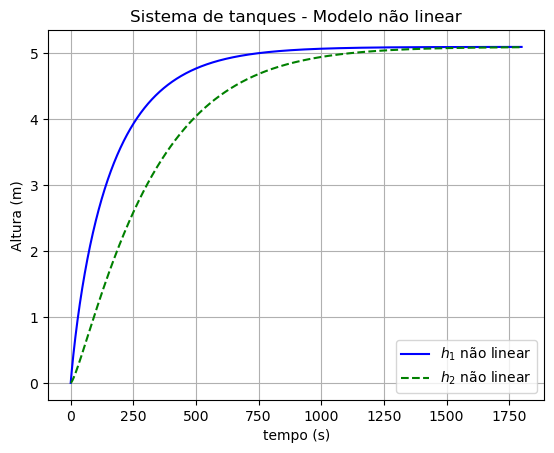

In [6]:
# Parameters
A1 = 20.0  # m^2
A2 = 20.0  # m^2
a1 = 0.1   # m^2
a2 = 0.1   # m^2
Q1 = 1.0   # m^3/s
Q2 = 0.0   # m^3/s

# Initial conditions
h1_0 = 0  # m
h2_0 = 0 # m
x0 = [h1_0, h2_0]

# Time range
t = np.arange(0, 1800, 0.3)

# Solve ODE for the nonlinear system
x_nl = odeint(tank_system_nonlinear, x0, t, args=(Q1, Q2, A1, A2, a1, a2))

# Plot results for the nonlinear model
plt.plot(t, x_nl[:, 0], 'b-', label='$h_1$ não linear')
plt.plot(t, x_nl[:, 1], 'g--', label='$h_2$ não linear')
plt.ylabel('Altura (m)')
plt.xlabel('tempo (s)')
plt.legend(loc='best')
plt.title('Sistema de tanques - Modelo não linear')
plt.grid()
plt.savefig('tank_system_nonlinear.png')
plt.show()

In [4]:

# Linearization around equilibrium points
h1_eq = 5.0  # Equilibrium height for Tank 1
h2_eq = 5.0  # Equilibrium height for Tank 2

# Symbolic variables for linearization
h1, h2, Q1_sym, Q2_sym = sy.symbols('h1 h2 Q1 Q2')

# Nonlinear equations
v_a1 = a1 * sy.sqrt(2 * 9.81 * h1)
v_a2 = a2 * sy.sqrt(2 * 9.81 * h2)

dh1dt = (Q1_sym - v_a1) / A1
dh2dt = (Q2_sym + v_a1 - v_a2) / A2

# Vector field
F = sy.Matrix([dh1dt, dh2dt])

# Calculate Jacobians
A_ss = F.jacobian([h1, h2])
B_ss = F.jacobian([Q1_sym, Q2_sym])

# Evaluate Jacobians at equilibrium points
A = A_ss.evalf(subs={h1: h1_eq, h2: h2_eq, Q1_sym: Q1, Q2_sym: Q2})
B = B_ss.evalf(subs={h1: h1_eq, h2: h2_eq, Q1_sym: Q1, Q2_sym: Q2})
A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
# Define C and D matrices
C = np.matrix([[1, 0], [0, 1]])
D = np.matrix([[0, 0], [0, 0]])

# Linear state-space model
tank_system_linear = ctrl.ss(A, B, C, D)
# Simulate linear system
yout, T, xout = ctrlmatlab.lsim(tank_system_linear, np.array([np.zeros_like(t),np.zeros_like(t)]).T, t, x0-np.array([h1_eq, h2_eq]))

# Adjust linear results to equilibrium
h1_lin = xout[:, 0] + h1_eq
h2_lin = xout[:, 1] + h2_eq

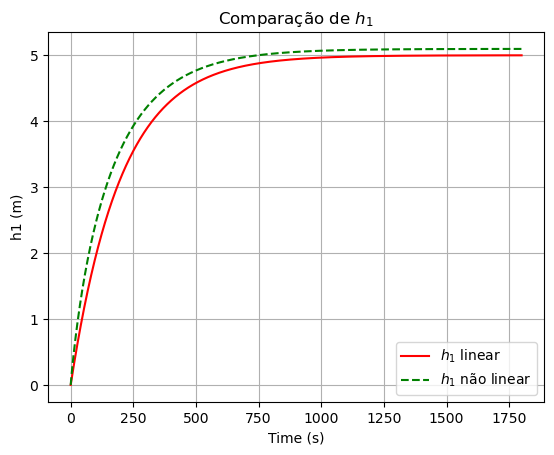

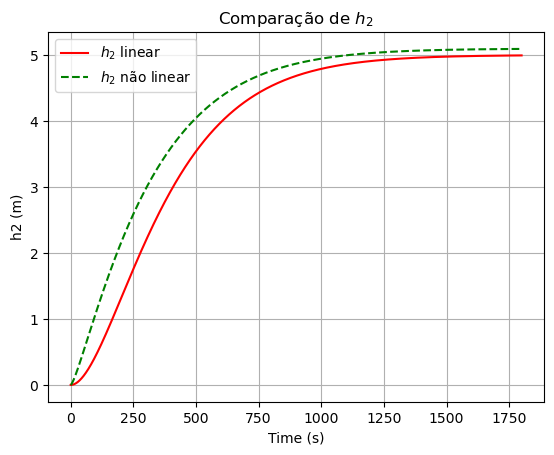

Erro percentual para h1:  1.9026280409478185 %
Erro percentual para h2:  1.9318705892388959 %


In [7]:

# Plot comparison between linear and nonlinear models for h1
plt.plot(T, h1_lin, 'r-', label='$h_1$ linear')
plt.plot(t, x_nl[:,0], 'g--', label='$h_1$ não linear')
plt.ylabel('h1 (m)')
plt.xlabel('Time (s)')
plt.legend(loc='best')
plt.title('Comparação de $h_1$')
plt.grid()
plt.savefig('tank_system_linearh1.png')
plt.show()
err_h1_perc = (np.max(x_nl[:, 0])-np.max(h1_lin))/np.max(x_nl[:, 0])
# Plot comparison between linear and nonlinear models for h2
plt.plot(T, h2_lin, 'r-', label='$h_2$ linear')
plt.plot(t, x_nl[:, 1], 'g--', label='$h_2$ não linear')
plt.ylabel('h2 (m)')
plt.xlabel('Time (s)')
plt.legend(loc='best')
plt.grid()
plt.title('Comparação de $h_2$')
plt.savefig('tank_system_linearh2.png')
plt.show()
err_h2_perc = (np.max(x_nl[:, 1])-np.max(h2_lin))/np.max(x_nl[:, 1])

print('Erro percentual para h1: ', err_h1_perc*100, '%')
print('Erro percentual para h2: ', err_h2_perc*100, '%')